In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
import os
from albumentations import (HorizontalFlip, ShiftScaleRotate, Normalize, Resize, Compose, GaussNoise)
from albumentations.pytorch import ToTensorV2
from skimage import io, transform
import matplotlib.pyplot as plt

import cv2
import random

In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [ ]:
# dowload the dataset from google drive 
! gdown --id 1QGmq8gloxGD3308vqilc0hzyukxjT52E

# unzip the dataset 
!unzip /content/stage1_test.zip

In [ ]:
###loading the data
class Nuclie_data(Dataset):
        def __init__(self,path):
            self.path = path
            self.folders = os.listdir(path)
            self.transforms = get_transforms(0.5, 0.5)
        
        def __len__(self):
            return len(self.folders)
              
        
        def __getitem__(self,idx):
            image_folder = os.path.join(self.path,self.folders[idx],'images/')
            #mask_folder = os.path.join(self.path,self.folders[idx],'masks/')
            image_path = os.path.join(image_folder,os.listdir(image_folder)[0])
            
            img = io.imread(image_path)[:,:,:3].astype('float32')
            img = transform.resize(img,(128,128))
            
            #mask = get_mask(mask_folder, 128, 128 ).astype('float32')
            #augmentation
            augmented = self.transforms(image=img)
            img = augmented['image']
            #mask = augmented['mask']
            return (img) 

In [ ]:
##convert the image into tensors
def get_transforms(mean, std):
            list_transforms = []
            
            list_transforms.extend(
                    [
                HorizontalFlip(p=0), # only horizontal flip as of now
                    ])
            list_transforms.extend(
                    [
            Normalize(mean=mean, std=std, p=1),
            ToTensorV2(),
                    ])
            list_trfms = Compose(list_transforms)
            return list_trfms


In [ ]:
##integrate the multiple masks into one mask
def get_mask(mask_folder,IMG_HEIGHT, IMG_WIDTH):
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_ in os.listdir(mask_folder):
            mask_ = io.imread(os.path.join(mask_folder,mask_))
            mask_ = transform.resize(mask_, (IMG_HEIGHT, IMG_WIDTH))
            mask_ = np.expand_dims(mask_,axis=-1)
            mask = np.maximum(mask, mask_)
              
    return mask

In [ ]:
# converting tensor to image
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1,2,0))
    std = np.array((0.5,0.5,0.5))
    mean = np.array((0.5,0.5,0.5))
    image  = std * image + mean
    image = image.clip(0,1)
    image = (image * 255).astype(np.uint8)
    return image

def mask_convert(mask):
    mask = mask.clone().cpu().detach().numpy()
    #mask = mask.transpose((1,2,0))
    std = np.array((0.5))
    mean = np.array((0.5))
    mask  = std * mask + mean
    mask = mask.clip(0,1)
    mask = np.squeeze(mask)
    return mask

In [ ]:
from google.colab import drive
drive.mount('/content/MyDrive')

Mounted at /content/MyDrive


In [ ]:
#loading the data
data_dir = '/content/stage1_test'
data = Nuclie_data(data_dir)

In [ ]:
#data size
print(data.__len__())

66


In [ ]:
#view the images and combined masks
def plot_img(no_):
    images = []
    for i in range(no_):
        
        n = random.randint(0,65)
        print(n)
        image = data.__getitem__(n)
        images.append(image)
    images = list(image.to(device) for image in images)
    plt.figure(figsize=(10,6))
    for idx in range(0,no_):
         image = image_convert(images[idx])
         plt.subplot(2,no_,idx+1)
         plt.title('image')
         plt.imshow(image)
    plt.show()

61
16
61
21
2


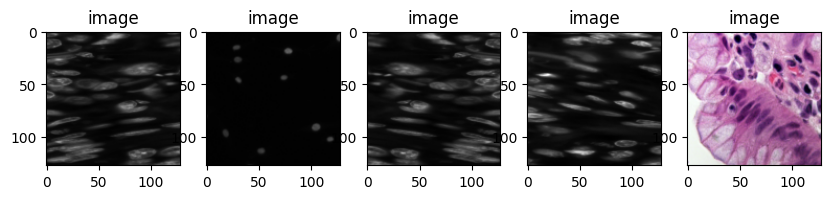

In [ ]:
plot_img(5)

In [ ]:
import torchvision.models.segmentation
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [ ]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(2)

In [ ]:
model_path = "/content/MyDrive/MyDrive/trained_model/individual_mask/2000_individal_batch6.torch"
model.load_state_dict(torch.load(model_path))
model.eval()
model.to(device)

In [ ]:
def get_predicted_box(pred, cutoff = 0.5):
    
    filtered_box = []
    for i in range(len(pred[0]['boxes'])):
        box=pred[0]['boxes'][i].detach().cpu().numpy()
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr > cutoff :
           filtered_box.append(box)
    return filtered_box

def plot_box(img, box):

    colors = (255, 0, 0)
    thickness = 1
    
    for idx in range(len(box)):
        tmp_box = box[idx]
        x_min = tmp_box[0]
        y_min = tmp_box[1]
        x_max = tmp_box[2]
        y_max = tmp_box[3]
        start_point = (int(x_min), int(y_min))
        end_point = (int(x_max), int(y_max))
        if idx == 0:
           plt_box = cv2.rectangle(image_convert(img), start_point, end_point, colors, thickness)
        else:
           plt_box = cv2.rectangle(plt_box, start_point, end_point, colors, thickness)

    return plt_box

def get_predicted_masks(image, pred, IMG_HEIGHT = 128, IMG_WIDTH = 128, cutoff = 0.7):
    
    ig = imag.detach().cpu().numpy()
    im2 =ig.copy()
    im2 = im2.transpose((1,2,0))
    for i in range(len(pred[0]['masks'])):
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr > 0.5 :   
           msk=pred[0]['masks'][i,0].detach().cpu().numpy()
           im2[:,:,0][msk>0.5] = random.randint(0,255)
           im2[:, :,1][msk > 0.5] = random.randint(0,255)
           im2[:, :,2][msk > 0.5] = random.randint(0,255)
    return im2.astype(np.uint8)

In [ ]:
def merged_box_img(img, box):

    colors = (255, 0, 0)
    thickness = 1
    
    for idx in range(len(box)):
        tmp_box = box[idx]
        x_min = tmp_box[0]
        y_min = tmp_box[1]
        x_max = tmp_box[2]
        y_max = tmp_box[3]
        start_point = (int(x_min), int(y_min))
        end_point = (int(x_max), int(y_max))
        if idx == 0:
           plt_box = cv2.rectangle(img, start_point, end_point, colors, thickness)
        else:
           plt_box = cv2.rectangle(plt_box, start_point, end_point, colors, thickness)

    return plt_box

In [ ]:
def get_prediction(num_, model):
    imag = data.__getitem__(num_)
    img = []
    img.append(imag)
    img = list(image.to(device) for image in img)

    # testing the model 
    with torch.no_grad():
         pred = model(img)

    #pred_box = get_predicted_box(pred, cutoff)
    #p_0 = plot_box(imag, pred_box)

    return imag, pred

In [ ]:
imag1, pred1, p1 = get_prediction(54, model)
imag2, pred2, p2 = get_prediction(15, model)
imag3, pred3, p3 = get_prediction(14, model)

In [ ]:
def get_combined_masks(imag, pred, cutoff = 0.5):
    #image_convert(imag1)
    imag_mak = get_predicted_masks_test(image_convert(imag), pred)
    pred_box = get_predicted_box(pred)
    img = merged_box_img(imag_mak, pred_box)
    #pred_mask = get_predicted_masks(imag, pred, cutoff = 0.5)
    #pred_mask = pred_mask.transpose((1, 2, 0)).astype(np.uint8).copy() 
    return img

In [ ]:
def get_predicted_masks_test(ig, pred, IMG_HEIGHT = 128, IMG_WIDTH = 128, cutoff = 0.7):
    
    #ig = imag.detach().cpu().numpy()
    im2 =ig.copy()
    #im2 = im2.transpose((1,2,0))
    for i in range(len(pred[0]['masks'])):
        scr=pred[0]['scores'][i].detach().cpu().numpy()
        if scr > 0.5 :   
           msk=pred[0]['masks'][i,0].detach().cpu().numpy()
           im2[:,:,0][msk>0.5] = random.randint(0,255)
           im2[:, :,1][msk > 0.5] = random.randint(0,255)
           im2[:, :,2][msk > 0.5] = random.randint(0,255)
    return im2.astype(np.uint8)

In [ ]:
imag1, pred1 = get_prediction(54, model)
pred_img1 = get_combined_masks(imag1, pred1, cutoff = 0.5)

imag2, pred2 = get_prediction(15, model)
pred_img2 = get_combined_masks(imag2, pred2, cutoff = 0.5)


imag3, pred3 = get_prediction(14, model)
pred_img3 = get_combined_masks(imag3, pred3, cutoff = 0.5)

In [ ]:
def plot_img(no_, plot_mask = True):
    images = []
    pred_ims = []
    pred_boxs = []
    n = len(no_)
        #pred_box = get_predicted_box(pred, cutoff)
    #p_0 = plot_box(imag, pred_box)
    for idx in range(n):
        imag, pred = get_prediction(no_[idx], model)
        pred_img = get_combined_masks(imag, pred, cutoff = 0.5)

        pd_box = get_predicted_box(pred, cutoff = 0.5)
        pred_box = plot_box(imag, pd_box)

        images.append(imag)
        pred_ims.append(pred_img)
        pred_boxs.append(pred_box)

    plt.figure(figsize=(10,7))
    for idx in range(0,n):
         image = image_convert(images[idx])
         plt.subplot(2,n,idx+1)
         plt.title('image')
         plt.imshow(image)

    for idx in range(0,n):
         #mask = mask_convert(masks[idx])
         if plot_mask:
            p = pred_ims[idx]
         else:
            p = pred_box[idx]
         plt.subplot(2,n,idx+n+1)
         plt.title('predicted mask')
         plt.imshow(p,cmap='gray')
    plt.show()

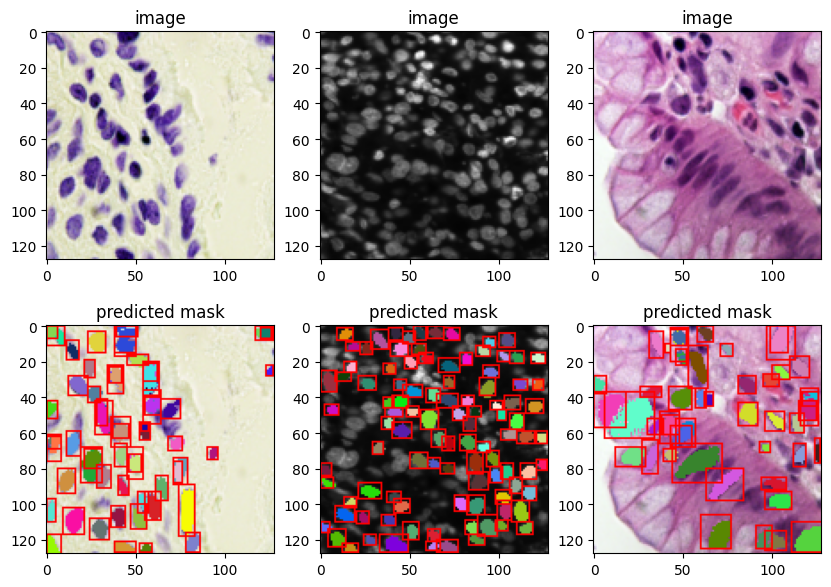

In [ ]:
image_id = [14, 54, 2]
plot_img(image_id)

## Semantic Segmentation

In [ ]:
def get_model_semantic(num_classes):
    #load the pre-trained model 
    model=torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True) 
    in_features = model.roi_heads.box_predictor.cls_score.in_features 
    model.roi_heads.box_predictor=FastRCNNPredictor(in_features,num_classes)

    return model

In [ ]:
model = get_model_semantic(2)
model.load_state_dict(torch.load("/content/MyDrive/MyDrive/trained_model/Combined_masks/1000_augmentation_batch8.torch"))
model.eval()
model.to(device)

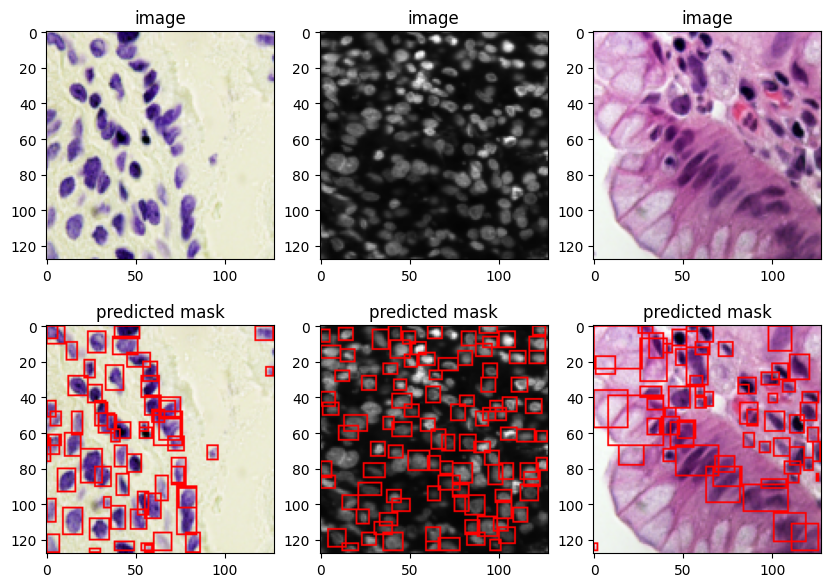

In [ ]:
image_id = [14, 54, 2]
plot_img(image_id)